<a href="https://colab.research.google.com/github/TheLemonPig/RL-SSM/blob/main/RL_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install Packages

In [1]:
# restart runtime after running and skip this cell
!pip install 'pymc>=5.9'
!pip install numpyro
!pip install git+https://github.com/lnccbrown/hssm@main
!pip install git+https://github.com/brown-ccv/hddm-wfpt@main

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.14.2
    Uninstalling pytensor-2.14.2:
      Successfully uninstalled pytensor-2.14.2
  Attempting uninstall: pymc
    Found existing installation: pymc 5.7.2
    Uninstalling pymc-5.7.2:
      Successfully uninstalled pymc-5.7.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 4.6 MB/s eta 0:00:00
  Cloning https://github.com/lnccbrown/hssm (to revision main) to /tmp/pip-req-build-0timjzj4
  Running command git clone --filter=blob:none --quiet https://github.com/lnccbrown/hssm /tmp/pip-req-build-0timjzj4
  Resolved https://github.com/lnccbrown/hssm to commit 19b24538a20938ffc4c8b0bf88ca35d6d51b4196
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━

##2. Import Packages

In [1]:
import numpyro
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import functools
from scipy.optimize import curve_fit
import pymc as pm
import arviz as az
from typing import List, Callable
from functools import partial
from tqdm import tqdm
import bambi as bmb
import itertools
import hddm_wfpt
import hssm

##3. Create Synthetic RL Model

###3a. helper functions

In [2]:
def softmax(qs, tau):
  safe_tau = np.abs(tau) + 1e-2
  return np.exp(qs/safe_tau) / np.exp(qs/safe_tau).sum()

def rescola(qt, alpha, reward):
  return qt + alpha * (reward - qt)

In [3]:
class Distribution:

  def __init__(self, func: Callable, kwargs):
    self.func: Callable = partial(func, **kwargs)

  def __call__(self):
    return self.func.__call__()

###3b. Single participant RL model

In [4]:
class SimpleRL:

  def __init__(self, n_trials: int, distributions: List[Distribution]):
    self.n_choices: int = len(distributions)
    self.n_trials: int = n_trials
    self.distributions: List[Distribution] = distributions
    self.qs: np.array = np.ones((self.n_choices,)) * 0.5
    self.q_trace: np.array = np.ones((self.n_trials,self.n_choices))
    self.rewards: np.array = np.zeros((self.n_trials))
    self.choices: np.array = np.zeros((self.n_trials),dtype=np.int32)

  def simulate(self, alpha, temperature):
    for i in range(self.n_trials):
      # Q-values are recorded to trace
      self.q_trace[i] = self.qs
      # softmax decision function
      ps = softmax(self.qs,temperature)
      # choice made based on weighted probabilities of Q-values
      choice = np.random.choice(a=self.n_choices,size=1,p=ps)[0]
      # choice is recorded to trace
      self.choices[i] = choice
      # reward calculated
      dist = self.distributions[choice]  # supply a list of distributions to choose from
      reward = dist()  # sample from distribution by calling it
      # Q-values updated
      self.rewards[i] = reward
      self.qs[choice] = rescola(self.qs[choice],alpha,reward)
    # Q-values trace returned
    # main data to be returned (basis for fits), is choices and rewards per trial
    return self.rewards, self.choices

####3bi. Simulate Basic Model

In [5]:
seed = 0
np.random.seed(seed)
mean_rewards = [-1.0,1.0]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":1.0}) for mn in mean_rewards]
n_trials = 1000
temperature = 0.8
alpha = 0.1

In [6]:
rl_model = SimpleRL(n_trials=n_trials, distributions=dists)
rewards, choices = rl_model.simulate(alpha,temperature)
qs = rl_model.q_trace

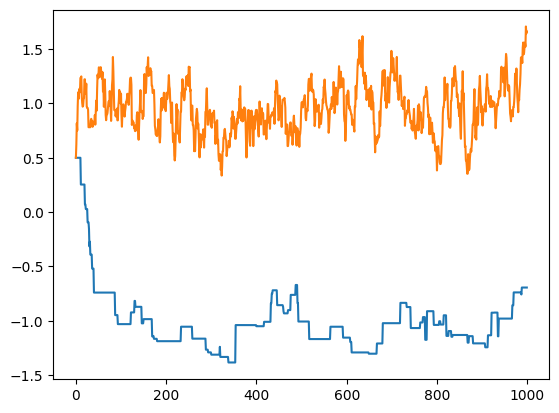

In [7]:
# plotting q values
plt.plot(qs)

###3c. Multiple Participants RL Model

In [10]:
class MultiRL:

  def __init__(self, n_trials: int, n_participants: int, distributions: List[Distribution]):
    self.participants: List[SimpleRL] = [
        SimpleRL(n_trials, distributions) for _ in range(n_participants)
    ]
    self.alphas = list()
    self.temperatures = list()

  def simulate(self, alpha_a, alpha_b, temperature_a, temperature_b):
    group_data = []
    for idx, participant_model in enumerate(self.participants):
      # sample participant parameters
      alpha = np.random.beta(alpha_a, alpha_b)
      temperature = np.random.beta(temperature_a, temperature_b)
      self.alphas.append(alpha)
      self.temperatures.append(temperature)
      participant_rewards, participants_choices = np.vstack(participant_model.simulate(alpha, temperature))
      assert sum(np.isnan(participant_rewards)) == 0, participant_rewards
      trial_col = np.arange(participant_model.n_trials).reshape((-1,1))
      idx_col = np.ones_like(trial_col) * idx
      group_data.append(np.concatenate([idx_col,participant_rewards.reshape((-1,1)),participants_choices.reshape((-1,1)),trial_col],axis=1))
    return np.concatenate(group_data)

  def get_params(self):
    return self.alphas, self.temperatures


####3ci. Simulate Model

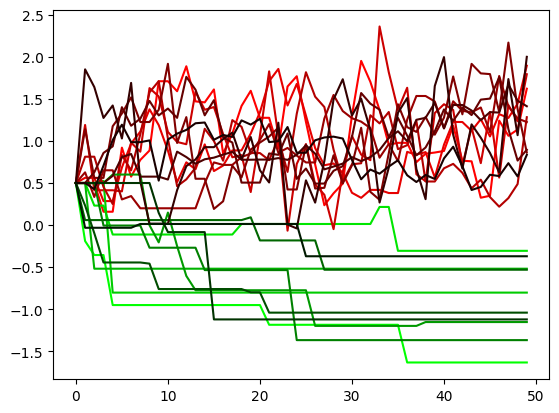

In [11]:
n_trials = 50
n_participants = 10
n_choices = len(dists)
multi_rl_model = MultiRL(n_trials=n_trials,n_participants=n_participants,distributions=dists)
data = multi_rl_model.simulate(alpha_a=2.0,alpha_b=5.0,temperature_a=2.0,temperature_b=2.0)
multi_qs = [participant.q_trace for participant in multi_rl_model.participants]
multi_qs[1][:,1]
for i in range(len(multi_qs)):
  qs = multi_qs[i]
  plt.plot(qs[:,1], c=(1-i/n_participants,0,0,1))
  plt.plot(qs[:,0], c=(0,1-i/n_participants,0,1))
plt.show()

##Run everything above here ^^^

##4. Define PyTensor Model

First multiloglike function - this one assumes alphas and betas are shape (n_participants,)

In [12]:
# parameters & variables
CM = pt.itensor3("CM") # choice matrices OVER PARTICIPANTS
RM = pt.dtensor3("RM") # reward matrices OVER PARTICIPANTS
# QM = pt.dmatrix("QM") # empty vectors to store q-values across trials OVER PARTICIPANTS
A = pt.dvector("A") # scalars of learning rates OVER PARTICIPANTS
B = pt.dvector("B") # scalars of RL decision temperatures OVER PARTICIPANTS
# mll = pt.dvector("mll")  # empty scalars to store ll value OVER PARTICIPANTS

def my_mll_func(CM, RM, A, B):

    # function for a single RL step
    # C: vector (participants, choices)
    # R: vector (participants, choices)
    # Q_tm1: matrix (participants, choices)
    # A: vector (participants, choices)
    def rl_step(C, R, Q_tm1, A):
        return Q_tm1 + pt.mul(A,pt.mul(C,(R - Q_tm1)))

    ### function to calculate loglikehood for each trial
    # C: matrix (participants, choices)
    # Qs: matrix (participants, choices)
    # B: vector (participants, choices)
    ## Ps: matrix
    ## P_select: vector
    # mll: vector
    def ll_def(C, Qs, mll, B):
        denom = pt.exp(pt.true_div(Qs,B)).sum(axis=1)
        denom = pt.repeat(denom.reshape((denom.shape[0],1)),n_choices,axis=-1)
        Ps = pt.true_div(
             pt.exp(pt.true_div(Qs,B)),
             denom
             )
        P_select = pt.mul(Ps,C).sum(axis=1)  # sum over choices
        mll = pt.log(P_select)
        return mll

    n_choices = 2
    mll = pt.zeros((A.shape[0]),dtype=pytensor.config.floatX)
    QM = pt.ones((A.shape[0], n_choices),dtype=pytensor.config.floatX) * 0.5
    # RM = pt.mul(RM,pt.ones_like((QM.shape[0])))
    A = A.reshape((A.shape[0],1))
    B = B.reshape((B.shape[0],1))
    AM = pt.repeat(A,n_choices,axis=1)
    BM = pt.repeat(B,n_choices,axis=1)

    ### scan function
    # CM: tensor3 [matrix] (trials,[participants, choices])
    # RM: tensor3 [matrix] (trials,[participants, choices])
    # A: matrix (participants, choices)
    # QM: matrix (participants, choices) --> tensor3 (trials, participants, choices)
    QsT3, updates = pytensor.scan(rl_step, sequences=[CM,RM], non_sequences = [AM], outputs_info=QM)

    ### scan function
    # CM: tensor3 [matrix] (trials,[participants, choices])
    # QsT3: tensor3 [matrix] (trials, [participants, choices])
    # B: matrix (participants, choices)
    # mll: scalar --> vector
    loglikes, updates = pytensor.scan(ll_def, sequences=[CM,QsT3], non_sequences=[BM], outputs_info=mll)

    return loglikes

output = my_mll_func(CM, RM, A, B)

mloglike_func = pytensor.function(inputs=[CM,RM,A,B],outputs=output)

In [13]:
# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 10
n_participants = 5
mll_test = np.zeros((n_participants,))
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
C_test_onehot = np.array(np.eye(n_choices)[C_test],dtype=np.int32)  # Remember to use this one
R_test = np.ones((n_trials,), dtype=np.int32) - 2 * C_test
R_test = np.repeat(R_test[:,np.newaxis],n_choices,axis=1)
a_test = 0.1
b_test = 1.0
CM_test_onehot = np.repeat(C_test_onehot[:,np.newaxis,:],n_participants,axis=1)
RM_test_repeat = np.repeat(R_test[:,np.newaxis,:],n_participants,axis=1)
QM_test = np.ones(shape=(n_participants,n_choices))
A_test = np.tile(a_test,(n_participants,))
A_test = np.array([0.0,0.1,0.2,0.3,0.4])
B_test = np.tile(b_test,(n_participants,))

# print(f"CM: {CM_test_onehot[:,0]}\nRM: {RM_test_repeat[:,0]}\nQM: {QM_test[0]}\nA: {A_test}\nB: {B_test}\nmll: ()")
# print(f"CM: {CM_test_onehot.shape}\nRM: {RM_test_repeat.shape}\nQM: {QM_test.shape}\nA: {A_test.shape}\nB: {B_test.shape}\nmll: ()")

# RL Loglikelihood function test
mloglike_func(CM_test_onehot,RM_test_repeat,A_test,B_test)

array([[-0.69314718, -0.66845965, -0.64439666, -0.62095705, -0.59813887],
       [-0.69314718, -0.79813887, -0.91301525, -1.03748795, -1.17110067],
       [-0.69314718, -0.8746102 , -1.06349651, -1.25184119, -1.43268481],
       [-0.69314718, -0.52108961, -0.39659405, -0.30792206, -0.24532554],
       [-0.69314718, -0.97501094, -1.24970004, -1.49455256, -1.69814417],
       [-0.69314718, -1.04450677, -1.36163788, -1.61628827, -1.80524595],
       [-0.69314718, -1.10938631, -1.45444089, -1.70378078, -1.87062776],
       [-0.69314718, -1.16960979, -1.53063759, -1.76606677, -1.91023778],
       [-0.69314718, -1.22524829, -1.59277916, -1.81015187, -1.93413616],
       [-0.69314718, -1.27645109, -1.64321608, -1.8412405 , -1.94852182]])

Second multiloglike function - this one assumes alphas and betas are shape (n_trials, n_participants)

In [14]:
# parameters & variables
CM = pt.itensor3("CM") # choice matrices OVER PARTICIPANTS
RM = pt.dtensor3("RM") # reward matrices OVER PARTICIPANTS
# QM = pt.dmatrix("QM") # empty vectors to store q-values across trials OVER PARTICIPANTS
A = pt.dmatrix("A") # scalars of learning rates OVER PARTICIPANTS
B = pt.dmatrix("B") # scalars of RL decision temperatures OVER PARTICIPANTS
# mll = pt.dvector("mll")  # empty scalars to store ll value OVER PARTICIPANTS

def my_mll2_func(CM, RM, A, B):

    # function for a single RL step
    # C: vector (participants, choices)
    # R: vector (participants, choices)
    # Q_tm1: matrix (participants, choices)
    # A: vector (participants, choices)
    def rl_step(C, R, A, Q_tm1):
        return Q_tm1 + pt.mul(A,pt.mul(C,(R - Q_tm1)))

    ### function to calculate loglikehood for each trial
    # C: matrix (participants, choices)
    # Qs: matrix (participants, choices)
    # B: vector (participants, choices)
    ## Ps: matrix
    ## P_select: vector
    # mll: vector
    def ll_def(C, Qs, B, mll):
        denom = pt.exp(pt.true_div(Qs,B)).sum(axis=1)
        denom = pt.repeat(denom.reshape((denom.shape[0],1)),n_choices,axis=1)
        Ps = pt.true_div(
             pt.exp(pt.true_div(Qs,B)),
             denom
             )
        P_select = pt.mul(Ps,C).sum(axis=1)  # sum over choices
        mll = pt.log(P_select)
        return mll

    n_choices = 2
    n_participants = A.shape[1]
    mll = pt.zeros((n_participants),dtype='float64')
    QM = pt.ones((n_participants, n_choices),dtype='float64') * 0.5
    # RM = pt.mul(RM,pt.ones_like((QM.shape[0])))
    A = A.reshape((A.shape[0],A.shape[1],1))
    B = B.reshape((B.shape[0],B.shape[1],1))
    AM = pt.repeat(A,n_choices,axis=2)
    BM = pt.repeat(B,n_choices,axis=2)

    ### scan function
    # CM: tensor3 [matrix] (trials,[participants, choices])
    # RM: tensor3 [matrix] (trials,[participants, choices])
    # A: matrix (participants, choices)
    # QM: matrix (participants, choices) --> tensor3 (trials, participants, choices)
    QsT3, updates = pytensor.scan(rl_step, sequences=[CM,RM,AM], non_sequences = [], outputs_info=QM)

    ### scan function
    # CM: tensor3 [matrix] (trials,[participants, choices])
    # QsT3: tensor3 [matrix] (trials, [participants, choices])
    # B: matrix (participants, choices)
    # mll: scalar --> vector
    loglikes, updates = pytensor.scan(ll_def, sequences=[CM,QsT3,BM], non_sequences=[], outputs_info=mll)

    return loglikes

output = my_mll2_func(CM, RM, A, B)

mloglike_func = pytensor.function(inputs=[CM,RM,A,B],outputs=output)

##5. Create PyMC Model

###5a. Create Synthetic Data using Synthetic Model

In [12]:
n_trials = 500
n_participants = 20
n_choices = len(dists)
multi_rl_model = MultiRL(n_trials=n_trials,n_participants=n_participants,distributions=dists)
data = multi_rl_model.simulate(alpha_a=2.0,alpha_b=5.0,temperature_a=2.0,temperature_b=2.0)

# set up our data
df = pd.DataFrame(data=data,columns=['Participant_ID','Rewards','Choices','Trial_Num'])
participant_ids, participants = pd.factorize(df['Participant_ID'])
coords = {
    "Participant": participants,
    "obs_id": np.arange(len(participant_ids)),
}

ids = df['Participant_ID']
mll_true = np.zeros((n_participants,))
CM_true = np.zeros((n_trials,n_participants), dtype=np.int32)
RM_true = np.zeros((n_trials,n_participants))
QM_true = np.ones((n_participants,n_choices)) * 0.5
for id in range(n_participants):
    CM_true[:,id] = df.loc[df['Participant_ID'] == id, 'Choices']
    RM_true[:,id] = df.loc[df['Participant_ID'] == id, 'Rewards']

CM_true_onehot = np.array(np.eye(n_participants,n_choices)[CM_true],dtype=np.int32)  # Remember to use this one
RM_true_repeat = np.repeat(np.expand_dims(RM_true,axis=2),n_choices,axis=2)
A_true, B_true = multi_rl_model.get_params()
A_true = np.array(A_true)
B_true = np.array(B_true)
print(f"Learning Rates:{A_true}\nTemperatures:{B_true}")

Learning Rates:[0.07162569 0.10555159 0.42272322 0.32794544 0.10963091 0.08431273
 0.43963072 0.04287414 0.36046137 0.50224164 0.46269516 0.27533515
 0.23769771 0.18734452 0.06368097 0.30381771 0.69662113 0.05333083
 0.06305124 0.28971908]
Temperatures:[0.78048131 0.56713664 0.15898072 0.57466336 0.31749733 0.3016196
 0.90550341 0.80959004 0.14178899 0.40497881 0.44325994 0.53604007
 0.29503328 0.5114351  0.70506851 0.08537706 0.80334976 0.65102393
 0.67173802 0.49340525]


###5b. Run Model Hierarchical Likelihoods from PyMC model

Create data

In [15]:
n_trials = 50
n_participants = 3
n_choices = len(dists)
multi_rl_model = MultiRL(n_trials=n_trials,n_participants=n_participants,distributions=dists)
data = multi_rl_model.simulate(alpha_a=2.0,alpha_b=5.0,temperature_a=2.0,temperature_b=2.0)

# set up our data
df = pd.DataFrame(data=data,columns=['Participant_ID','Rewards','Choices','Trial_Num'])
participant_ids, participants = pd.factorize(df['Participant_ID'])
coords = {
    "Participant": participants,
    "obs_id": np.arange(len(participant_ids)),
}

Preprocess

In [16]:
hier_data = df[['Participant_ID','Choices','Rewards']].copy()
hier_data = hier_data.rename(columns={'Participant_ID':'participant_id', 'Choices':'choices', 'Rewards':'rewards'})
hier_data['rt'] = 0
hier_data['response'] = 0
n_participants = len(hier_data['participant_id'].unique())
trial_col = pd.Series(list(itertools.chain.from_iterable([range(hier_data.shape[0]//n_participants) for _ in range(n_participants) ])))
hier_data['trial'] = trial_col
norm = False
if norm:
    #hier_data['choices'] = np.tile(np.array(hier_data.loc[hier_data['participant_id']==0.0,'choices']),3)
    hier_data['rewards'] = np.tile(np.array(hier_data.loc[hier_data['participant_id']==0.0,'rewards']),3)
C = np.array(hier_data['choices'],dtype=np.int32)
C_onehot = np.array(np.eye(n_choices)[C],dtype=np.int32)
hier_data['choice_0'] = C_onehot[:,0]
hier_data['choice_1'] = C_onehot[:,1]
del hier_data['choices']
hier_data['participant_id'] = hier_data['participant_id'].apply(lambda x: int(x))
hier_data['n_participants'] = hier_data['participant_id'].max() + 1
hier_data['participant_id'] = hier_data['participant_id'].apply(lambda x: str(x))

Format for wrapper function

In [17]:
#nhier_data = hier_data.loc[hier_data['participant_id'] == '1']
nhier_data = hier_data
nhier_data['n_participants'] = 1
n_trials = len(nhier_data['trial'].unique())
n_participants = len(nhier_data['participant_id'].unique())
data = np.array(nhier_data.copy())
alphas = (np.ones((data.shape[0])) * 0.1)
betas = (np.ones((data.shape[0])) * 0.1)
choice_0 = np.array(data[:,5], dtype=np.int32)
choice_1 = np.array(data[:,6], dtype=np.int32)
rewards = np.array(data[:,1], dtype=np.float64)
participants = np.array(data[:,-1], dtype=np.int32)

Wrapper for first likelihood function

In [16]:
def my_hdll(alphas, betas, choice_0, choice_1, rewards, participants):
#def my_hdll(data, alphas, betas, choice_0, choice_1, rewards,participants):
    R = rewards
    n_participants = pt.cast(pt.max(participants), 'int32')
    #n_participants = 3
    n_trials = 50
    n_choices = 2
    #shaped_alphas = alphas.reshape((n_participants,n_trials)).dimshuffle([1,0])
    #shaped_alphas = alphas.reshape((n_participants,n_trials)).transpose((1,0))
    #shaped_betas = betas.reshape((n_participants,n_trials)).dimshuffle([1,0])
    shaped_alphas = alphas.reshape((n_trials,n_participants))
    shaped_betas = betas.reshape((n_trials,n_participants))
    alphas = pt.max(shaped_alphas,axis=0).flatten()
    betas = pt.max(shaped_betas,axis=0).flatten()
    #choice_0 = choice_0.reshape((n_participants,n_trials)).dimshuffle([1,0])
    #choice_1 = choice_1.reshape((n_participants,n_trials)).dimshuffle([1,0])
    choice_0 = choice_0.reshape((n_trials,n_participants))
    choice_1 = choice_1.reshape((n_trials,n_participants))
    Cs = pt.stack([choice_0,choice_1],axis=-1)
    #R = R.reshape((n_participants,n_trials)).dimshuffle([1,0])
    R = R.reshape((n_trials,n_participants))
    #R = R.reshape((R.shape[0],R.shape[1],1)).dimshuffle([0,1,2])
    R = R.reshape((R.shape[0],R.shape[1],1))
    RM = pt.repeat(R,n_choices,axis=2)
    CM = Cs
    return my_mll_func(CM,RM,alphas,betas).flatten()

Second likelihood wrapper function

In [17]:
def my_hdll2(data, alphas, betas, choice_0, choice_1, rewards,participants):
    R = rewards
    n_participants = pt.cast(pt.max(participants), 'int32')
    n_trials = pt.constant(50,dtype=np.int32)
    n_choices = pt.constant(2,dtype=np.int32)
    #shaped_alphas = alphas.reshape((n_participants,n_trials)).transpose((1,0))
    #shaped_betas = betas.reshape((n_participants,n_trials)).transpose((1,0))
    shaped_alphas = alphas.reshape((n_trials,n_participants))
    shaped_betas = betas.reshape((n_trials,n_participants))
    alphas = shaped_alphas
    betas = shaped_betas
    #choice_0 = choice_0.reshape((n_participants,n_trials)).transpose((1,0))
    #choice_1 = choice_1.reshape((n_participants,n_trials)).transpose((1,0))
    choice_0 = choice_0.reshape((n_trials,n_participants))
    choice_1 = choice_1.reshape((n_trials,n_participants))
    Cs = pt.stack([choice_0,choice_1],axis=-1)
    #R = R.reshape((n_participants,n_trials,1)).transpose((1,0,2))
    R = R.reshape((n_trials,n_participants))
    R = R.reshape((n_trials,n_participants,1))
    RM = pt.repeat(R,n_choices,axis=2)
    CM=Cs
    #CM = Cs.reshape((n_trials, n_participants, n_choices))
    return my_mll2_func(CM,RM,alphas,betas).flatten()

In [18]:
with pm.Model(coords=coords) as hierarchical_model:
    # Data
    CM1 = pm.ConstantData('myCM', choice_0)
    CM2 = pm.ConstantData('myCM2', choice_1)
    RM = pm.ConstantData('myRM', rewards)
    P = pm.ConstantData('myP', participants)

    # mlogl = MultiLogLike(my_ll_func,R,C,IDs,n_ids,n_trials)

    # Hyperpriors for group nodes
    alpha_a = pm.Gamma("alpha_a", alpha = 3. , beta = 0.5)
    alpha_b = pm.Gamma("alpha_b", alpha = 3. , beta = 0.5)
    beta_a = pm.Gamma("beta_a", alpha = 3. , beta = 0.5)
    beta_b = pm.Gamma("beta_b", alpha = 3. , beta = 0.5)

    A = pm.Beta(name="A",alpha=alpha_a,beta=alpha_b,dims="Participant")
    B = pm.Beta(name="B",alpha=beta_a,beta=beta_b,dims="Participant")

    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("likelihood", my_hdll(A, B, CM1, CM2, RM, P))
    # Use custom number of draws to replace the HMC based defaults
    idata_mh = pm.sample(2000, tune=1000, chains=1, nuts_sampler="numpyro")

TypeError: The broadcast pattern of the output of scan (Matrix(float64, shape=(?, ?))) is inconsistent with the one provided in `output_info` (Vector(float64, shape=(1,))). The output on axis 0 is `False`, but it is `True` on axis 1 in `output_info`. This can happen if one of the dimension is fixed to 1 in the input, while it is still variable in the output, or vice-verca. You have to make them consistent, e.g. using pytensor.tensor.{unbroadcast, specify_broadcastable}.

###5c. Results

####5ci. Group: Constant; Participant: Uniform

In [ ]:
idata_mh.sample_stats.data_vars['diverging'].mean()

<xarray.DataArray 'diverging' ()>
array(0.0015)

In [ ]:
idata_mh.posterior.data_vars["B"].var()

<xarray.DataArray 'B' ()>
array(0.06080366)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

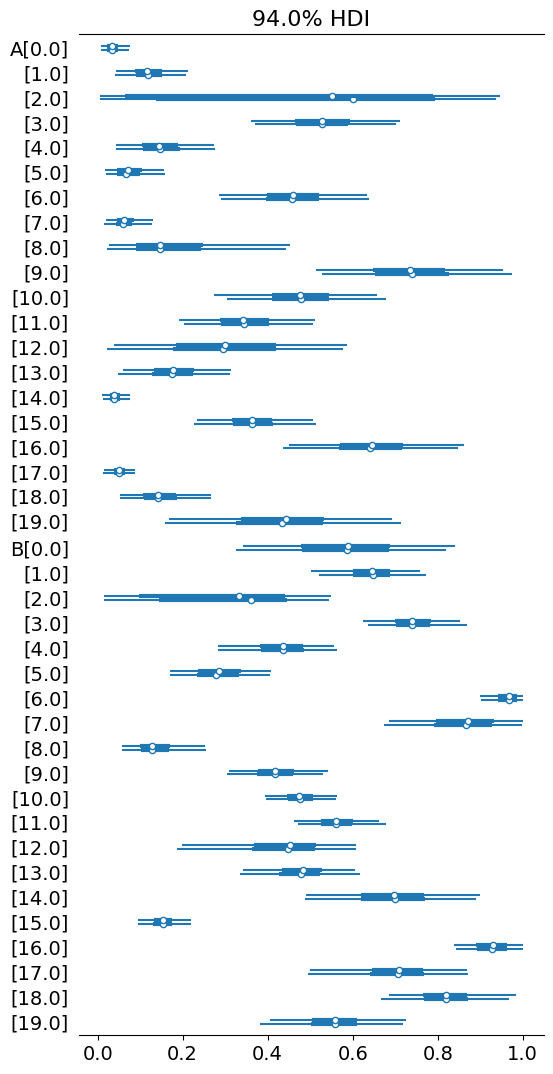

In [ ]:
az.plot_forest(idata_mh)

####5cii. Group: Gamma; Participant: Beta

In [ ]:
idata_mh.sample_stats.data_vars['diverging'].mean()

In [ ]:
idata_mh.posterior.data_vars["B"].var()

In [ ]:
az.plot_forest(idata_mh)

####5ciii.

####5civ.

In [ ]:
idata_mh.sample_stats.data_vars['diverging'].mean()

<xarray.DataArray 'diverging' ()>
array(0.)

In [ ]:
az.forest_plot(idata_mh)

In [ ]:
# Arviz forest_plot
# Trial / Participant Number analysis: use Mean and Variance of Posteriors

array([[<Axes: title={'center': 'alpha_a'}>,
        <Axes: title={'center': 'alpha_a'}>],
       [<Axes: title={'center': 'alpha_b'}>,
        <Axes: title={'center': 'alpha_b'}>],
       [<Axes: title={'center': 'beta_a'}>,
        <Axes: title={'center': 'beta_a'}>],
       [<Axes: title={'center': 'beta_b'}>,
        <Axes: title={'center': 'beta_b'}>],
       [<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'B'}>, <Axes: title={'center': 'B'}>]],
      dtype=object)

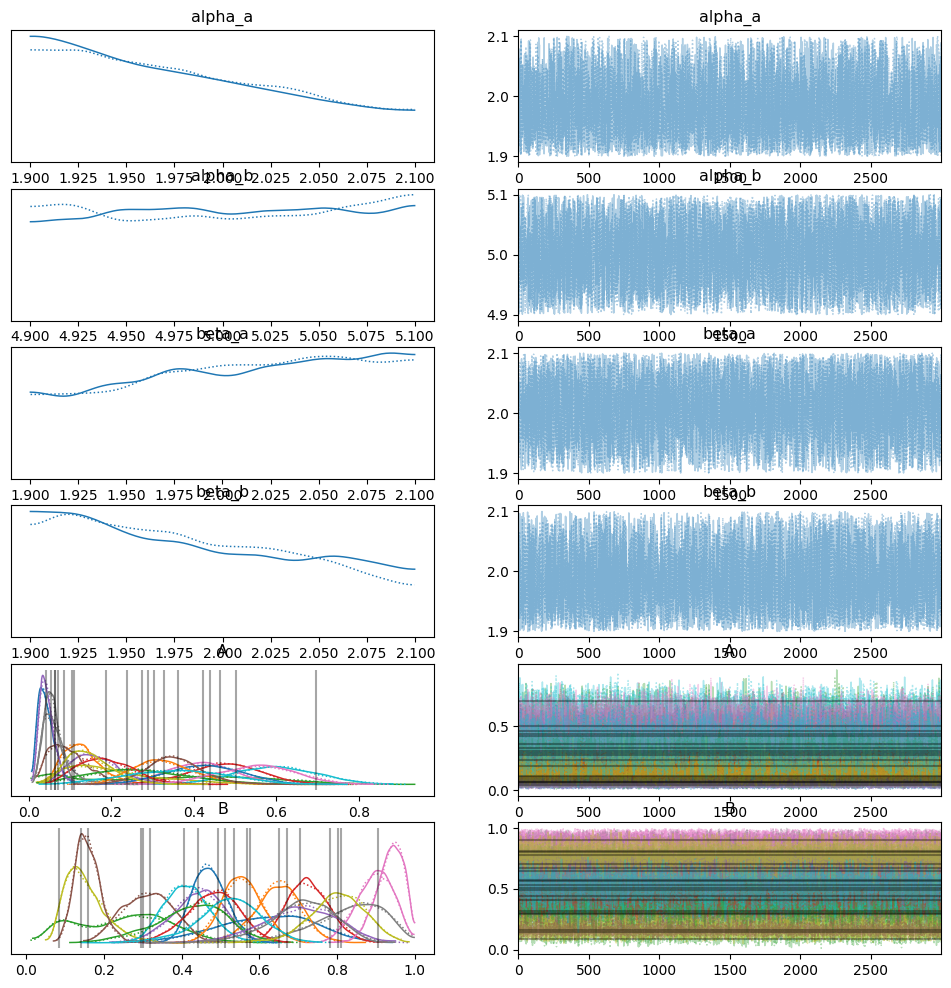

In [ ]:
# Betas hierarchical
az.plot_trace(idata_mh, lines=[
    ("A", {}, A_true),
    ("B", {}, B_true),
      ])

array([[<Axes: title={'center': 'hyper_mu_A'}>,
        <Axes: title={'center': 'hyper_mu_A'}>],
       [<Axes: title={'center': 'A_prelogit'}>,
        <Axes: title={'center': 'A_prelogit'}>],
       [<Axes: title={'center': 'hyper_mu_B'}>,
        <Axes: title={'center': 'hyper_mu_B'}>],
       [<Axes: title={'center': 'B_prelogit'}>,
        <Axes: title={'center': 'B_prelogit'}>],
       [<Axes: title={'center': 'hyper_sigma_A'}>,
        <Axes: title={'center': 'hyper_sigma_A'}>],
       [<Axes: title={'center': 'hyper_sigma_B'}>,
        <Axes: title={'center': 'hyper_sigma_B'}>],
       [<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'B'}>, <Axes: title={'center': 'B'}>]],
      dtype=object)

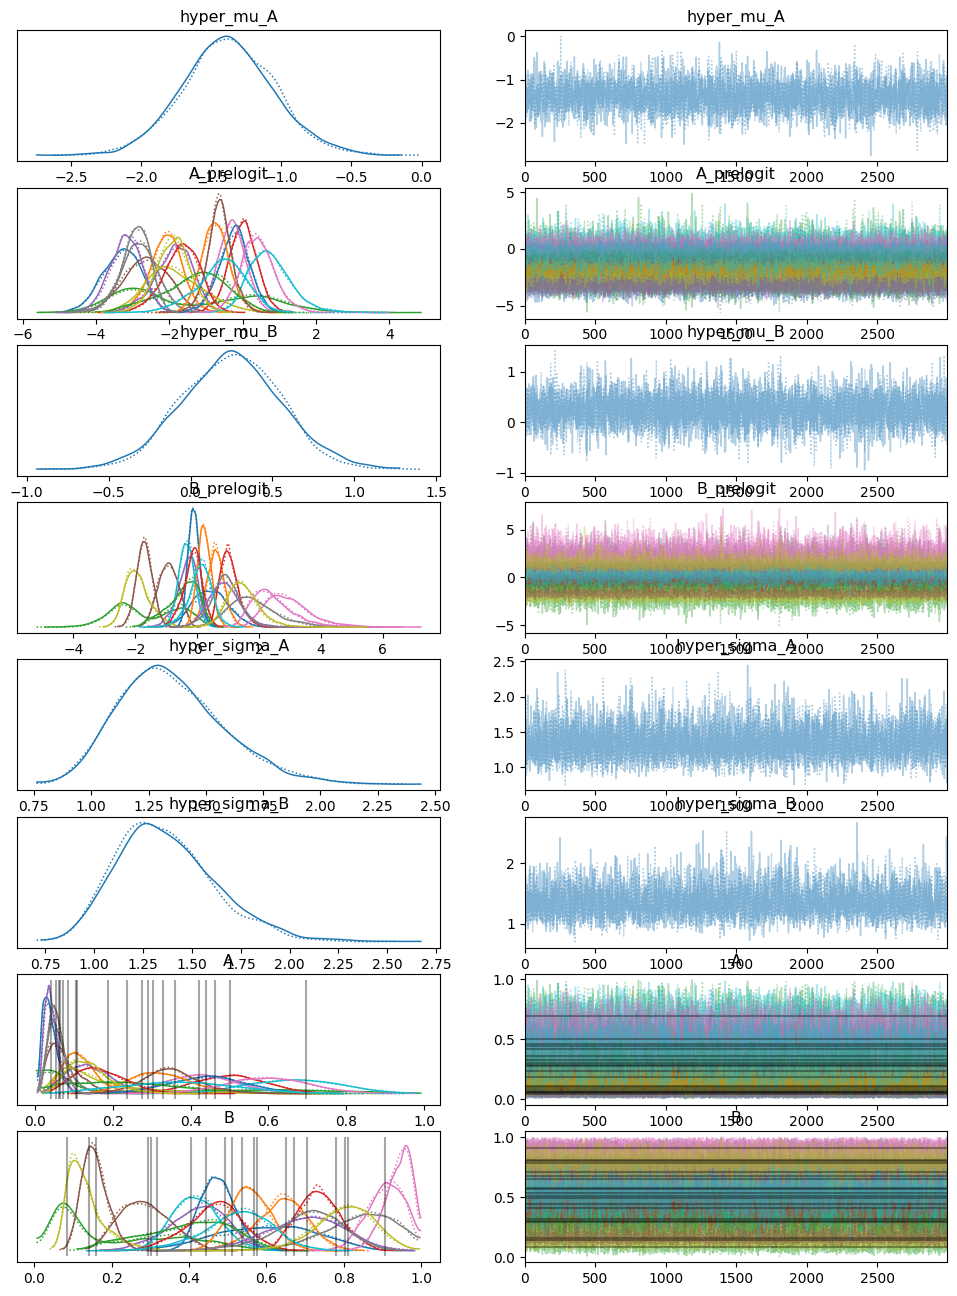

In [ ]:
# Centered hierarchical
az.plot_trace(idata_mh, lines=[
    ("A", {}, A_true),
    ("B", {}, B_true),
      ])

array([[<Axes: title={'center': 'hyper_mu_A'}>,
        <Axes: title={'center': 'hyper_mu_A'}>],
       [<Axes: title={'center': 'A_pre'}>,
        <Axes: title={'center': 'A_pre'}>],
       [<Axes: title={'center': 'hyper_mu_B'}>,
        <Axes: title={'center': 'hyper_mu_B'}>],
       [<Axes: title={'center': 'B_pre'}>,
        <Axes: title={'center': 'B_pre'}>],
       [<Axes: title={'center': 'hyper_sigma_A'}>,
        <Axes: title={'center': 'hyper_sigma_A'}>],
       [<Axes: title={'center': 'hyper_sigma_B'}>,
        <Axes: title={'center': 'hyper_sigma_B'}>],
       [<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'B'}>, <Axes: title={'center': 'B'}>]],
      dtype=object)

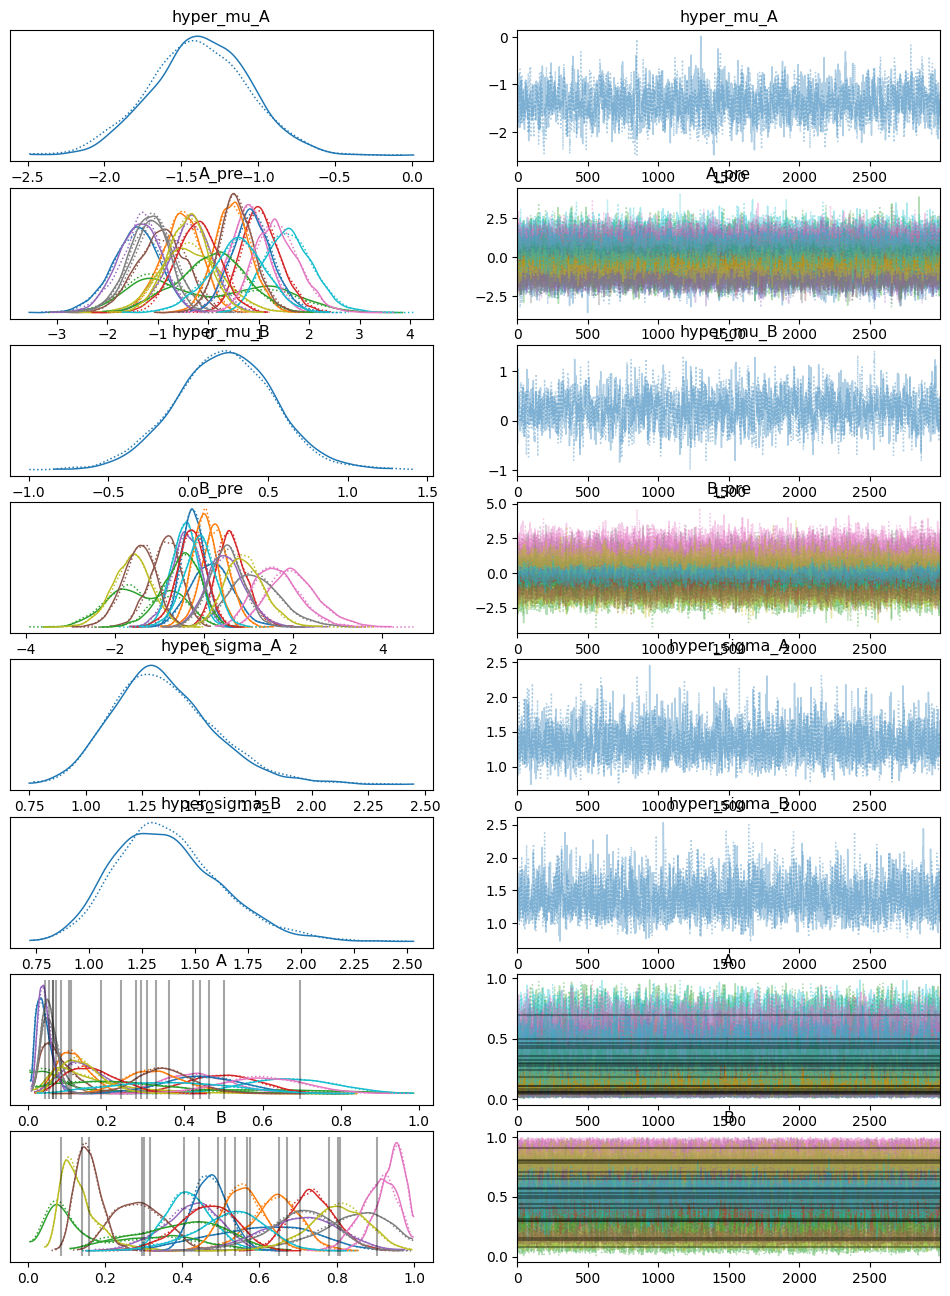

In [ ]:
# Non-centered hierarchical
az.plot_trace(idata_mh, lines=[
    ("A", {}, A_true),
    ("B", {}, B_true),
      ])

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'A_pre'}>,
        <Axes: title={'center': 'A_pre'}>],
       [<Axes: title={'center': 'hyper_mu_B'}>,
        <Axes: title={'center': 'hyper_mu_B'}>],
       [<Axes: title={'center': 'B_pre'}>,
        <Axes: title={'center': 'B_pre'}>],
       [<Axes: title={'center': 'hyper_sigma_B'}>,
        <Axes: title={'center': 'hyper_sigma_B'}>],
       [<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'B'}>, <Axes: title={'center': 'B'}>]],
      dtype=object)

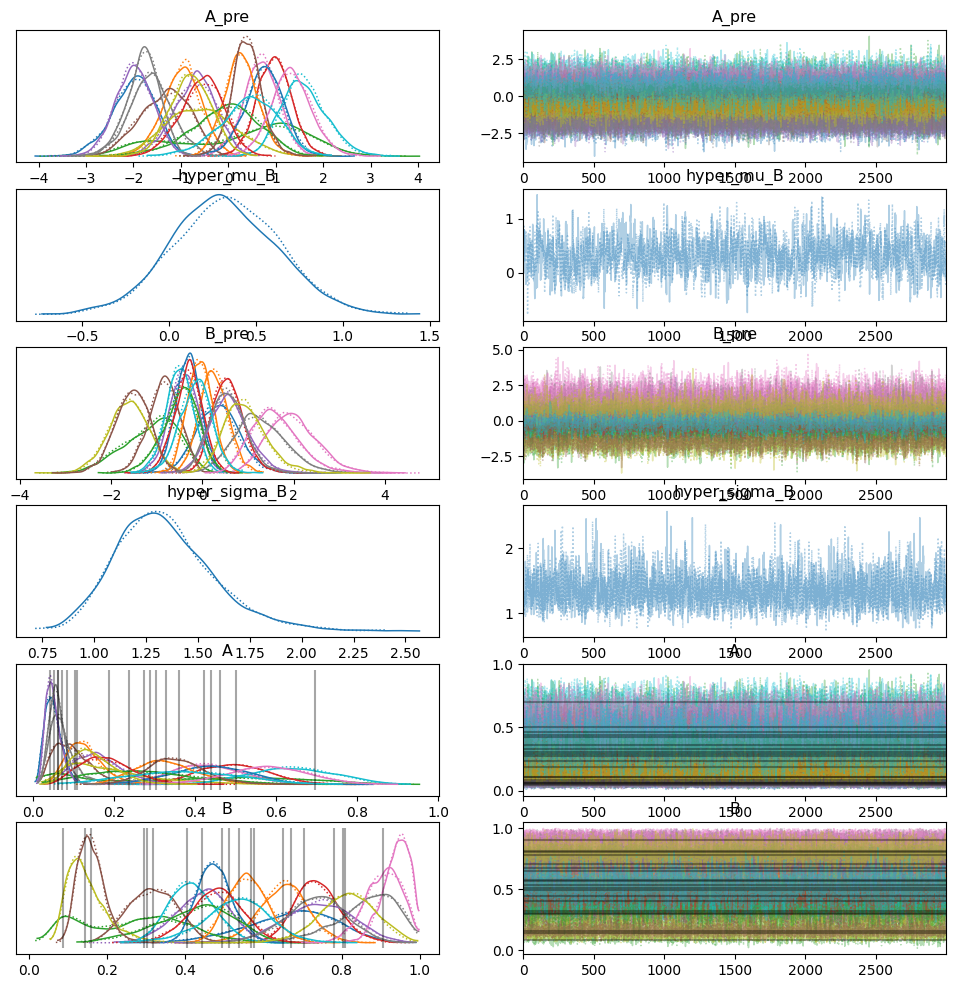

In [ ]:
# Non-centered non-hierarchical

az.plot_trace(idata_mh, lines=[
    ("A", {}, A_true),
    ("B", {}, B_true),
      ])

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'hyper_mu_A'}>,
        <Axes: title={'center': 'hyper_mu_A'}>],
       [<Axes: title={'center': 'A_pre'}>,
        <Axes: title={'center': 'A_pre'}>],
       [<Axes: title={'center': 'hyper_mu_B'}>,
        <Axes: title={'center': 'hyper_mu_B'}>],
       [<Axes: title={'center': 'B_pre'}>,
        <Axes: title={'center': 'B_pre'}>],
       [<Axes: title={'center': 'hyper_sigma_A'}>,
        <Axes: title={'center': 'hyper_sigma_A'}>],
       [<Axes: title={'center': 'hyper_sigma_B'}>,
        <Axes: title={'center': 'hyper_sigma_B'}>],
       [<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'B'}>, <Axes: title={'center': 'B'}>]],
      dtype=object)

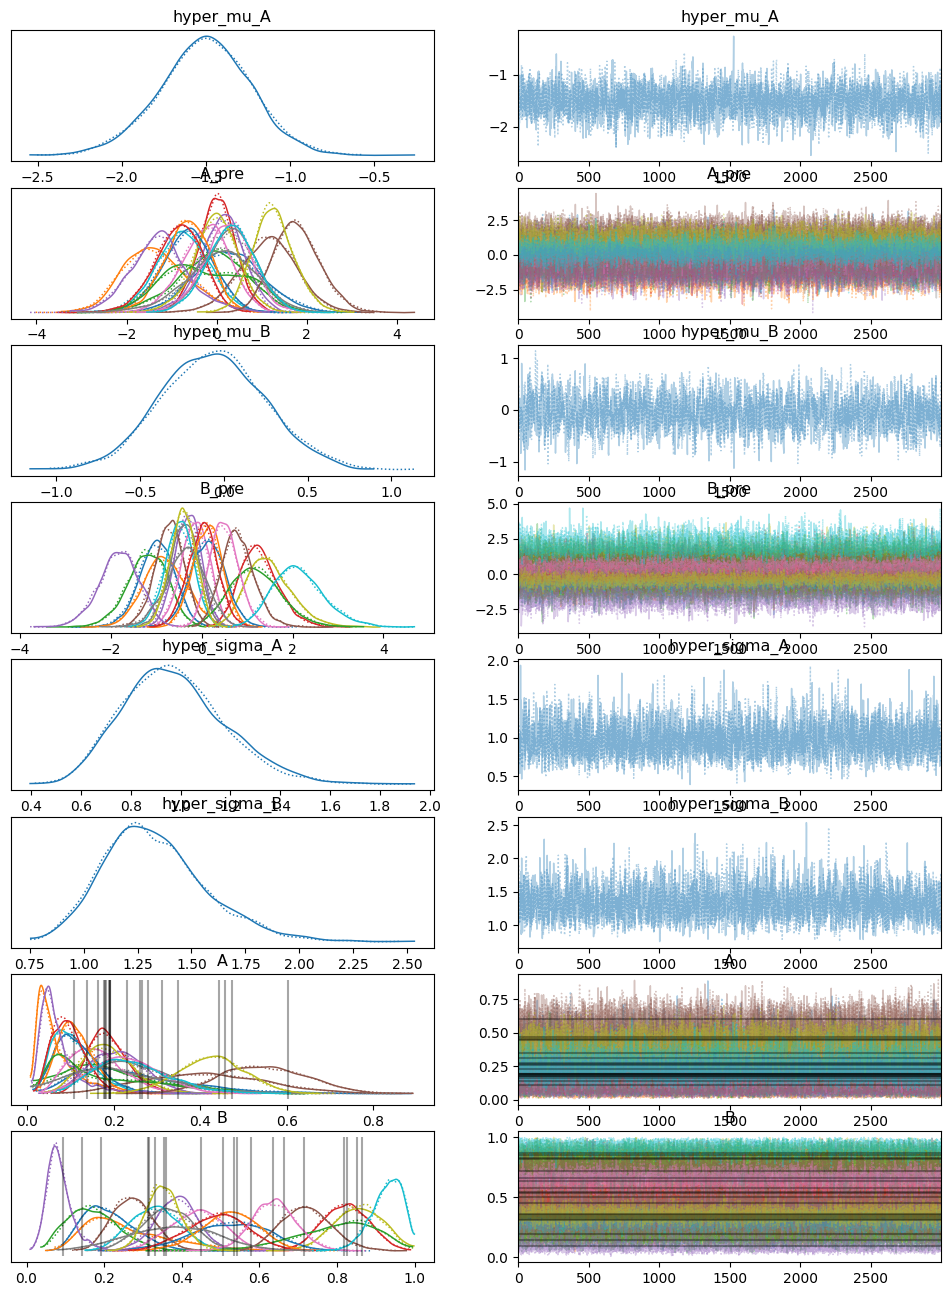

In [ ]:
# Non-centered hierarchical
az.plot_trace(idata_mh, lines=[
    ("A", {}, A_true),
    ("B", {}, B_true),
      ])

##Integrate with HSSM

### Non-hierarchical

In [14]:
# parameters & variables
C = pt.imatrix("C") # choice matrix
R = pt.dvector("R") # reward matrix
a = pt.dscalar("a") # scalar of learning rate
b = pt.dscalar("b") # scalar of RL decision temperatures

def my_ll_func(C, R, a, b):
    # function for a single RL step
    def rl_step(c, r, q_tm1, a):
        return q_tm1 + pt.mul(c,pt.mul(a,(r - q_tm1)))

    # function to calculate loglikehood for each trial
    def ll_def(c, qs, ll, b):
        ps = pt.true_div(pt.exp(pt.true_div(qs,b)),pt.exp(pt.true_div(qs,b)).sum())
        p_select = pt.mul(ps,c).sum()
        ll = pt.log(p_select)
        return ll

    n_choices = 2
    ll = pt.zeros((),dtype='float64')
    Q = pt.ones((n_choices),dtype='float64') * 0.5
    aV = pt.mul(a,pt.ones_like((Q.shape[0])))
    bV = pt.mul(b,pt.ones_like((Q.shape[0])))
    RM = pt.mul(R,pt.ones_like((Q.shape[0])))

    # scan function build
    Qs, updates = pytensor.scan(rl_step, sequences=[C,R], non_sequences = [aV], outputs_info=Q)

    # scan function build
    loglikes, updates = pytensor.scan(ll_def, sequences=[C,Qs], non_sequences=[bV], outputs_info=ll)

    # final output
    #loglike = loglikes.sum()
    return loglikes


output = my_ll_func(C, R, a, b)

loglike_func = pytensor.function(inputs=[C,R,a,b],outputs=output)

In [15]:
# parameters & variables
C = pt.imatrix("C") # choice matrix
R = pt.dvector("R") # reward matrix
#Q = pt.dvector("Q") # empty vector to store q-values
a = pt.dscalar("a") # scalar of learning rate
b = pt.dscalar("b") # scalar of RL decision temperatures

output = my_ll_func(C, R, a, b)

loglike_func = pytensor.function(inputs=[C,R,a,b],outputs=output)

In [16]:
np.random.seed(0)
n_choices = 2
n_trials = 10
ll_test = 0
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
C_test_onehot = np.array(np.eye(n_choices)[C_test],dtype=np.int32)  # Remember to use this one
# R_test = np.ones((n_trials,)) - 2 * C_test
R_test = np.random.randint(low=-1,high=n_choices,size=(n_trials,))
# R_test = np.repeat(R_test[:,np.newaxis],n_choices,axis=1)
Q_test = np.ones(shape=(n_choices,)) * 0.5
a_test = 0.1
b_test = 0.5
loglike_func(C_test_onehot, R_test, a_test, b_test)

array([-0.74439666, -0.59813887, -0.74965892, -0.58918502, -0.97345464,
       -1.13693893, -1.29583848, -1.15698823, -1.17284899, -1.05258043])

In [ ]:
def my_ll_blackbox(data, alpha, beta, rewards):
    C = np.array(data[:,0], dtype=np.int32)
    R = rewards
    n_choices = C.max() + 1
    C_onehot = np.array(np.eye(n_choices)[C],dtype=np.int32)
    C = C_onehot
    return loglike_func(C,R,alpha,beta)

In [ ]:
rl_model = SimpleRL(n_trials=20, distributions=dists)
rewards, choices = rl_model.simulate(0.1,0.5)
simple_data = pd.DataFrame(data=np.stack([choices,rewards], axis=-1), columns=['rt', 'response'])
simple_data = simple_data.rename(columns={'rt': 'rewards'})
simple_data['rt'] = 0
data = np.array(simple_data)
print(data.shape)
print(data[:,1].shape)
my_ll_blackbox(data,0.1,0.5,data[:,1])

(20, 3)
(20,)


array([-0.90417561, -0.87594175, -0.80826822, -0.42365214, -1.24081776,
       -0.26119229, -0.20079925, -0.16411151, -0.17535501, -0.16447447,
       -0.19035342, -1.81687175, -0.18699984, -0.19997471, -0.12948423,
       -0.15601443, -2.10584702, -0.12354463, -0.10936556, -0.08380729])

In [ ]:
rl_model = SimpleRL(n_trials=20, distributions=dists)
rewards, choices = rl_model.simulate(0.1,0.5)
simple_data = pd.DataFrame(data=np.stack([choices,rewards], axis=-1), columns=['rt', 'response'])
simple_data = simple_data.rename(columns={'rt': 'rewards'})
simple_data['rt'] = 0
data = np.array(simple_data)
# simple_data = pd.DataFrame(data=np.stack([choices,rewards], axis=-1), columns=['rt', 'response'])
model = hssm.HSSM(
    data=data,
    model="rl",
    hierarchical=False,
    loglik=my_ll_blackbox,
    loglik_kind="blackbox",
    # analytical
    model_config={
        "list_params": ["alpha", "beta"],
        "bounds": {
            "alpha": (0,1),
            "beta": (0.1,1),
        },
        "extra_fields": ['rewards'],
    },
    #"extra_namespace":
    #t=bmb.Prior("Uniform", lower=0.0, upper=1.0, initval=0.1),
)
sample = model.sample()

In [ ]:
sample

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

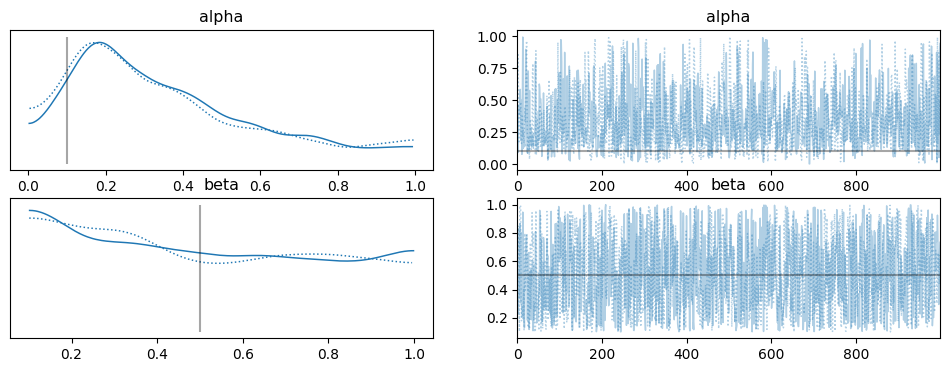

In [ ]:
az.plot_trace(sample, var_names=['alpha', 'beta'], lines=[('alpha',{},0.1),('beta',{},0.5)])

<Axes: xlabel='alpha', ylabel='beta'>

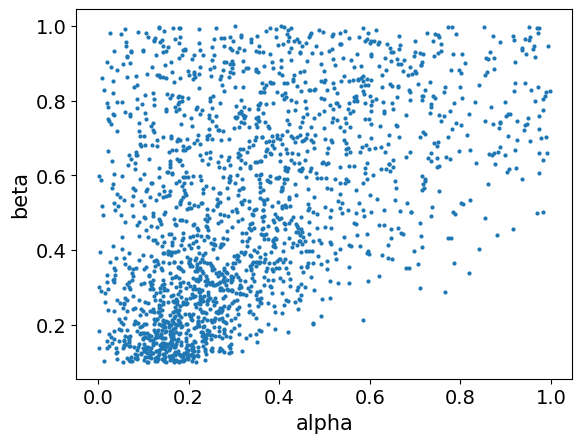

In [ ]:
az.plot_pair(sample, var_names=['alpha', 'beta'])

### Hierarchical

In [ ]:
list(itertools.chain.from_iterable([range(n_trials) for _ in range(n_participants) ]))

In [ ]:
import itertools

In [ ]:
hier_data = df[['Participant_ID','Choices','Rewards']].copy()
hier_data = hier_data.rename(columns={'Participant_ID':'participant_id', 'Choices':'choices', 'Rewards':'rewards'})
hier_data['rt'] = 0
hier_data['response'] = 0
n_participants = len(hier_data['participant_id'].unique())
trial_col = pd.Series(list(itertools.chain.from_iterable([range(hier_data.shape[0]//n_participants) for _ in range(n_participants) ])))
hier_data['trial'] = trial_col
hier_data

participant_id  choices   rewards  rt  response  trial
0                0.0      0.0 -1.422233   0         0      0
1                0.0      0.0 -0.653192   0         0      1
2                0.0      1.0 -0.451298   0         0      2
3                0.0      0.0 -2.012878   0         0      3
4                0.0      1.0  2.281849   0         0      4
...              ...      ...       ...  ..       ...    ...
9995            19.0      1.0  0.575554   0         0    495
9996            19.0      1.0  1.336654   0         0    496
9997            19.0      1.0  1.907966   0         0    497
9998            19.0      1.0  1.290077   0         0    498
9999            19.0      1.0  0.121331   0         0    499

[10000 rows x 6 columns]

In [ ]:
def my_hll_blackbox(data, alpha, beta, participant_id, choices, rewards):
    C = np.array(choices, dtype=np.int32)
    R = rewards
    n_choices = 2
    C_onehot = np.array(np.eye(n_choices)[C],dtype=np.int32)
    Q_slot = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX) * 0.5
    ll_slot = 0

    C = C_onehot
    Q = Q_slot
    ll = ll_slot
    # pll = np.zeros((n_trials,n_participants))
    pll = np.zeros((n_trials*20))
    # pll = 0
    for idx in range(n_participants):

      pC = C[participant_id==idx]
      pR = R[participant_id==idx]
      pQ = Q
      palpha = alpha[idx]
      pbeta = beta[idx]
      pll[idx*500:(idx+1)*500] = loglike_func(pC,pR,palpha,pbeta,)
      # pll += loglike_func(pC,pR,pQ,palpha,pbeta,ll)
      # pll += loglike_func(pC,pR,pQ,palpha,pbeta,ll).sum()
    return pll

In [ ]:
# def my_hll_blackbox(data, alpha, beta, participant_id, choices, rewards):
#       C = np.array(choices, dtype=np.int32)
#       R = rewards
#       n_choices = 2
#       C_onehot = np.array(np.eye(n_choices)[C],dtype=np.int32)
#       RM = R.reshape((-1,len(alpha),n_choices))
#       CM_onehot = R.reshape((-1,len(alpha),n_choices))

In [ ]:
n_trials = len(hier_data['trial'].unique())
n_participants = len(hier_data['participant_id'].unique())
data = np.array(hier_data.copy())
alphas = np.ones((n_participants))
betas = np.ones((n_participants))
my_hll_blackbox(data,alphas,betas,data[:,0],data[:,1],data[:,2]).shape

[0 0 1 ... 1 1 1]


(10000,)

In [ ]:
def make_generalized_sigmoid_simple(a,b):
    def invlink_(x):
        return a + ((b - a) / (1 + pt.exp(-x)))
    return invlink_

def make_generalized_logit_simple(a,b):
    def link_(x):
        return pt.log((x - a) / (b - x))
    return link_

def build_generalized_sigmoid_links_simple(a,b):
    invlink_ = make_generalized_sigmoid_simple(a,b)
    link_ = make_generalized_logit_simple(a,b)
    return {'name': 'generalized_logit',
            'link': link_,
            'linkinv': invlink_,
            'linkinv_backend': invlink_}

model_config_hier={
        "list_params": ["alpha", "beta"],
        "bounds": {
            "alpha": (0.01,0.99),
            "beta": (0.01,0.99),
        },
        "extra_fields": ['participant_id','choices','rewards'],
    }

In [ ]:
model = hssm.HSSM(
    data=hier_data,
    model='hll',
    loglik=my_hll_blackbox,
    loglik_kind="blackbox",
    model_config=model_config_hier,
    include = [
                    {
                        "name": "alpha",
                        "formula": "alpha ~ 1 + (1|participant_id)", # + (1|participant_id)
                        "link": bmb.Link(**build_generalized_sigmoid_links_simple(model_config_hier['bounds']['alpha'][0],model_config_hier['bounds']['alpha'][1])),
                    },
                    {
                        "name": "beta",
                        "formula": "rl_alpha ~ 1 + (1|participant_id)",
                        "link": bmb.Link(**build_generalized_sigmoid_links_simple(model_config_hier['bounds']['beta'][0],model_config_hier['bounds']['beta'][1])),
                    }
    ]
    #t=bmb.Prior("Uniform", lower=0.0, upper=1.0, initval=0.1),
)

hier_sample = model.sample()

You supplied a model 'hll', which is currently not supported in the ssm_simulators package. An error will be thrown when sampling from the random variable or when using any posterior or prior predictive sampling methods.


ValueError: Not enough samples to build a trace.

###Differentiable

In [ ]:
data = pt.matrix("data")
alpha = pt.dscalar("alpha")
beta = pt.dscalar("beta")
rewards = pt.dvector("rewards")
choice_0 = pt.ivector("choice_0")
choice_1 = pt.ivector("choice_0")

#def my_dll(data, alpha, beta, choice_0, choice_1, rewards):
def my_dll(alpha, beta, choice_0, choice_1, rewards):
    R = rewards
    Cs = pt.stack([choice_0,choice_1],axis=-1)
    n_choices = 2
    return my_ll_func(Cs,R,alpha,beta)

dll_output = my_dll(alpha, beta, choice_0, choice_1, rewards)

my_dll_func = pytensor.function(inputs=[alpha, beta, choice_0, choice_1, rewards], outputs=[dll_output])

In [ ]:
rl_model = SimpleRL(n_trials=20, distributions=dists)
rewards, choices = rl_model.simulate(0.1,0.5)
C = np.array(choices,dtype=np.int32)
C_onehot = np.array(np.eye(n_choices)[C],dtype=np.int32)
choice_0 = C_onehot[:,0]
choice_1 = C_onehot[:,1]
simple_data = pd.DataFrame(data=np.stack([choice_0,choice_1,rewards], axis=-1), columns=['choice_0', 'choice_1', 'rewards'])
simple_data['rt'] = 0
simple_data['response'] = 0
data = np.array(simple_data)
# my_dll_blackbox(data,0.1,0.5,data[:,0],data[:,1],data[:,2])

In [ ]:
simple_data

choice_0  choice_1   rewards  rt  response
0        0.0       1.0  1.950088   0         0
1        0.0       1.0  0.848643   0         0
2        1.0       0.0 -0.855956   0         0
3        0.0       1.0  2.454274   0         0
4        0.0       1.0  1.443863   0         0
5        0.0       1.0  1.333674   0         0
6        0.0       1.0  2.494079   0         0
7        1.0       0.0 -1.205158   0         0
8        0.0       1.0 -1.552990   0         0
9        0.0       1.0  1.653619   0         0
10       0.0       1.0  3.269755   0         0
11       1.0       0.0 -2.454366   0         0
12       0.0       1.0  2.532779   0         0
13       0.0       1.0  2.469359   0         0
14       0.0       1.0  0.112214   0         0
15       0.0       1.0 -0.980796   0         0
16       1.0       0.0  0.230291   0         0
17       0.0       1.0  2.202380   0         0
18       0.0       1.0 -0.048553   0         0
19       0.0       1.0 -0.420018   0         0

In [ ]:
!pip install -Uqq ipdb
import ipdb
%pdb on

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.5 MB/s eta 0:00:00
Automatic pdb calling has been turned ON


In [ ]:
%pdb on

Automatic pdb calling has been turned ON


In [ ]:
def make_generalized_sigmoid_simple(a,b):
    def invlink_(x):
        return a + ((b - a) / (1 + pt.exp(-x)))
    return invlink_

def make_generalized_logit_simple(a,b):
    def link_(x):
        return pt.log((x - a) / (b - x))
    return link_

def build_generalized_sigmoid_links_simple(a,b):
    invlink_ = make_generalized_sigmoid_simple(a,b)
    link_ = make_generalized_logit_simple(a,b)
    return {'name': 'generalized_logit',
            'link': link_,
            'linkinv': invlink_,
            'linkinv_backend': invlink_}

In [ ]:
rl_model = SimpleRL(n_trials=20, distributions=dists)
rewards, choices = rl_model.simulate(0.1,0.5)
C = np.array(choices,dtype=np.int32)
C_onehot = np.array(np.eye(n_choices)[C],dtype=np.int32)
choice_0 = C_onehot[:,0]
choice_1 = C_onehot[:,1]
simple_data = pd.DataFrame(data=np.stack([choice_0,choice_1,rewards], axis=-1), columns=['choice_0', 'choice_1', 'rewards'])
simple_data['rt'] = 0
simple_data['response'] = 0
data = np.array(simple_data)
# simple_data = pd.DataFrame(data=np.stack([choices,rewards], axis=-1), columns=['rt', 'response'])
model = hssm.HSSM(
    data=simple_data,
    model="rl",
    hierarchical=False,
    loglik=my_dll,
    loglik_kind="analytical",
    # analytical
    model_config={
        "list_params": ["alpha", "beta"],
        "bounds": {
            "alpha": (0,1),
            "beta": (0.1,1),
        },
        "extra_fields": ['choice_0','choice_1','rewards'],
        "backend": "numpyro"
    },
    #"extra_namespace":
    #t=bmb.Prior("Uniform", lower=0.0, upper=1.0, initval=0.1),
)
sample = model.sample()
#%debug sample = model.sample()

NameError: name 'my_dll' is not defined

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([<Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'alpha'}>], dtype=object)

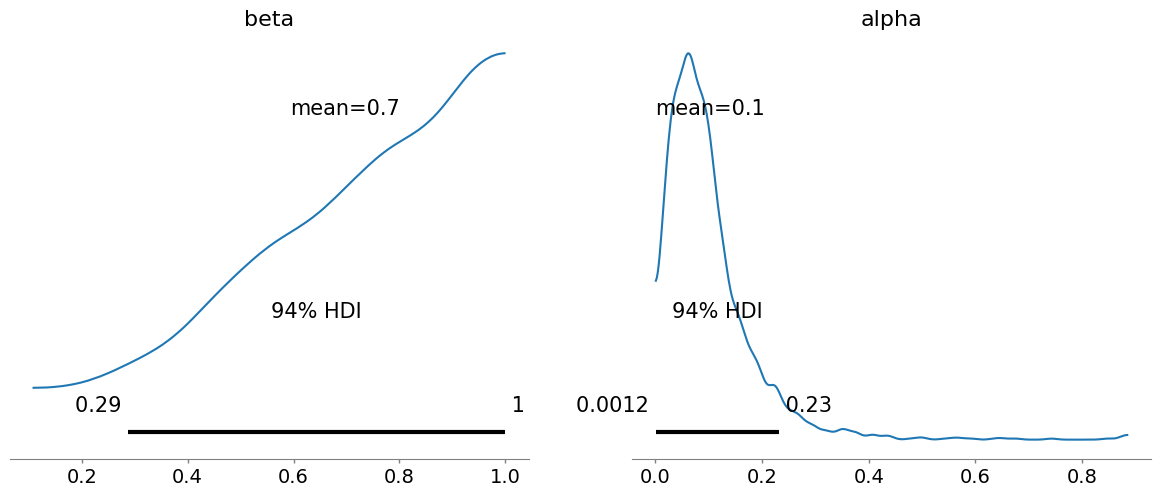

In [ ]:
az.plot_posterior(sample)

###Hierarchical and Differentiable

In [19]:
n_trials = 50
n_participants = 3
n_choices = len(dists)
multi_rl_model = MultiRL(n_trials=n_trials,n_participants=n_participants,distributions=dists)
data = multi_rl_model.simulate(alpha_a=2.0,alpha_b=5.0,temperature_a=2.0,temperature_b=2.0)

# set up our data
df = pd.DataFrame(data=data,columns=['Participant_ID','Rewards','Choices','Trial_Num'])
participant_ids, participants = pd.factorize(df['Participant_ID'])
coords = {
    "Participant": participants,
    "obs_id": np.arange(len(participant_ids)),
}

ids = df['Participant_ID']
mll_true = np.zeros((n_participants,))
CM_true = np.zeros((n_trials,n_participants), dtype=np.int32)
RM_true = np.zeros((n_trials,n_participants))
QM_true = np.ones((n_participants,n_choices)) * 0.5
for id in range(n_participants):
    CM_true[:,id] = df.loc[df['Participant_ID'] == id, 'Choices']
    RM_true[:,id] = df.loc[df['Participant_ID'] == id, 'Rewards']

CM_true_onehot = np.array(np.eye(n_participants,n_choices)[CM_true],dtype=np.int32)  # Remember to use this one
RM_true_repeat = np.repeat(np.expand_dims(RM_true,axis=2),n_choices,axis=2)
A_true, B_true = multi_rl_model.get_params()
A_true = np.array(A_true)
B_true = np.array(B_true)
print(f"Learning Rates:{A_true}\nTemperatures:{B_true}")

Learning Rates:[0.21055647 0.10204803 0.39591365]
Temperatures:[0.62028732 0.95244152 0.41494721]


In [20]:
hier_data = df[['Participant_ID','Choices','Rewards']].copy()
hier_data = hier_data.rename(columns={'Participant_ID':'participant_id', 'Choices':'choices', 'Rewards':'rewards'})
hier_data['rt'] = 0
hier_data['response'] = 0
n_participants = len(hier_data['participant_id'].unique())
trial_col = pd.Series(list(itertools.chain.from_iterable([range(hier_data.shape[0]//n_participants) for _ in range(n_participants) ])))
hier_data['trial'] = trial_col
norm = False
if norm:
    #hier_data['choices'] = np.tile(np.array(hier_data.loc[hier_data['participant_id']==0.0,'choices']),3)
    hier_data['rewards'] = np.tile(np.array(hier_data.loc[hier_data['participant_id']==0.0,'rewards']),3)
C = np.array(hier_data['choices'],dtype=np.int32)
C_onehot = np.array(np.eye(n_choices)[C],dtype=np.int32)
hier_data['choice_0'] = C_onehot[:,0]
hier_data['choice_1'] = C_onehot[:,1]
del hier_data['choices']
hier_data['participant_id'] = hier_data['participant_id'].apply(lambda x: int(x))
hier_data['n_participants'] = hier_data['participant_id'].max() + 1
hier_data['participant_id'] = hier_data['participant_id'].apply(lambda x: str(x))

In [22]:
hier_data.loc[hier_data['trial']==1]

participant_id   rewards  rt  response  trial  choice_0  choice_1  \
1                0  1.370056   0         0      1         0         1   
51               1 -2.616474   0         0      1         1         0   
101              2  0.926075   0         0      1         0         1   

     n_participants  
1                 3  
51                3  
101               3

In [23]:
data = pt.matrix("data")
alphas = pt.dvector("alphas")
betas = pt.dvector("betas")
rewards = pt.dvector("rewards")
choice_0 = pt.ivector("choice_0")
choice_1 = pt.ivector("choice_1")
participants = pt.ivector("participants")

def my_hdll(alphas, betas, choice_0, choice_1, rewards, participants):
#def my_hdll(data, alphas, betas, choice_0, choice_1, rewards,participants):
    R = rewards
    n_participants = pt.cast(pt.max(participants), 'int32')
    #n_participants = 3
    n_trials = 50
    n_choices = 2
    #shaped_alphas = alphas.reshape((n_participants,n_trials)).dimshuffle([1,0])
    #shaped_alphas = alphas.reshape((n_participants,n_trials)).transpose((1,0))
    #shaped_betas = betas.reshape((n_participants,n_trials)).dimshuffle([1,0])
    shaped_alphas = alphas.reshape((n_trials,n_participants))
    shaped_betas = betas.reshape((n_trials,n_participants))
    alphas = pt.max(shaped_alphas,axis=0).flatten()
    betas = pt.max(shaped_betas,axis=0).flatten()
    #choice_0 = choice_0.reshape((n_participants,n_trials)).dimshuffle([1,0])
    #choice_1 = choice_1.reshape((n_participants,n_trials)).dimshuffle([1,0])
    choice_0 = choice_0.reshape((n_trials,n_participants))
    choice_1 = choice_1.reshape((n_trials,n_participants))
    Cs = pt.stack([choice_0,choice_1],axis=-1)
    #R = R.reshape((n_participants,n_trials)).dimshuffle([1,0])
    R = R.reshape((n_trials,n_participants))
    #R = R.reshape((R.shape[0],R.shape[1],1)).dimshuffle([0,1,2])
    R = R.reshape((R.shape[0],R.shape[1],1))
    RM = pt.repeat(R,n_choices,axis=2)
    CM = Cs
    return my_mll_func(CM,RM,alphas,betas).flatten()

#hdll_output = my_hdll(alphas, betas, choice_0, choice_1, rewards, participants)

#mloglike_func = pytensor.function(inputs=[alphas,betas,choice_0,choice_1,rewards, participants],outputs=hdll_output)

In [24]:
data = pt.matrix("data")
alphas = pt.dvector("alphas")
betas = pt.dvector("betas")
rewards = pt.dvector("rewards")
choice_0 = pt.ivector("choice_0")
choice_1 = pt.ivector("choice_1")
participants = pt.ivector("participants")

#def my_hdll2(data, alphas, betas, choice_0, choice_1, rewards):
#def my_hdll2(alphas, betas, choice_0, choice_1, rewards):
#def my_hdll2(alphas, betas, choice_0, choice_1, rewards, participants):
def my_hdll2(data, alphas, betas, choice_0, choice_1, rewards,participants):
    R = rewards
    n_participants = pt.cast(pt.max(participants), 'int32')
    n_trials = pt.constant(50,dtype=np.int32)
    n_choices = pt.constant(2,dtype=np.int32)
    #shaped_alphas = alphas.reshape((n_participants,n_trials)).transpose((1,0))
    #shaped_betas = betas.reshape((n_participants,n_trials)).transpose((1,0))
    shaped_alphas = alphas.reshape((n_trials,n_participants))
    shaped_betas = betas.reshape((n_trials,n_participants))
    alphas = shaped_alphas
    betas = shaped_betas
    #choice_0 = choice_0.reshape((n_participants,n_trials)).transpose((1,0))
    #choice_1 = choice_1.reshape((n_participants,n_trials)).transpose((1,0))
    choice_0 = choice_0.reshape((n_trials,n_participants))
    choice_1 = choice_1.reshape((n_trials,n_participants))
    Cs = pt.stack([choice_0,choice_1],axis=-1)
    #R = R.reshape((n_participants,n_trials,1)).transpose((1,0,2))
    R = R.reshape((n_trials,n_participants))
    R = R.reshape((n_trials,n_participants,1))
    RM = pt.repeat(R,n_choices,axis=2)
    CM=Cs
    #CM = Cs.reshape((n_trials, n_participants, n_choices))
    return my_mll2_func(CM,RM,alphas,betas).flatten()

#hdll_output2 = my_hdll2(alphas, betas, choice_0, choice_1, rewards, participants)

#mloglike_func2 = pytensor.function(inputs=[alphas,betas,choice_0,choice_1,rewards, participants],outputs=hdll_output2)

In [ ]:
# This line inverts the data so that when you call pytensor's reshape on it, you will get the correctly transformed data
#.reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')

In [18]:
n_trials = len(hier_data['trial'].unique())
n_participants = len(hier_data['participant_id'].unique())
data = np.array(hier_data.copy())
alphas = (np.ones((data.shape[0])) * 0.1).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
betas = (np.ones((data.shape[0])) * 0.1).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
choice_0 = np.array(data[:,5], dtype=np.int32).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
choice_1 = np.array(data[:,6], dtype=np.int32).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
rewards = np.array(data[:,1], dtype=np.float64).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
participants = np.array(data[:,-1], dtype=np.int32).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
#np.array(hier_data['participant_id']).reshape((n_participants,n_trials,),order='C').transpose([1,0])
np.array(hier_data['participant_id']).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F').reshape((n_trials,n_participants),order='C')

array([['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1', '2'],
       ['0', '1'

In [26]:
nhier_data = hier_data.loc[hier_data['participant_id'] == '1']
nhier_data['n_participants'] = 1
n_trials = len(nhier_data['trial'].unique())
n_participants = len(nhier_data['participant_id'].unique())
data = np.array(nhier_data.copy())
alphas = (np.ones((data.shape[0])) * 0.1)
betas = (np.ones((data.shape[0])) * 0.1)
choice_0 = np.array(data[:,5], dtype=np.int32)
choice_1 = np.array(data[:,6], dtype=np.int32)
rewards = np.array(data[:,1], dtype=np.float64)
participants = np.array(data[:,-1], dtype=np.int32)
mloglike_func(alphas,betas,choice_0,choice_1,rewards,participants)

<ipython-input-26-f0ac013b47df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nhier_data['n_participants'] = 1


TypeError: Too many parameter passed to pytensor function

In [32]:
n_trials = len(hier_data['trial'].unique())
n_participants = len(hier_data['participant_id'].unique())
data = np.array(hier_data.copy())
alphas = (np.ones((data.shape[0])) * 0.1).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
betas = (np.ones((data.shape[0])) * 0.1).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
choice_0 = np.array(data[:,5], dtype=np.int32).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
choice_1 = np.array(data[:,6], dtype=np.int32).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
rewards = np.array(data[:,1], dtype=np.float64).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
participants = np.array(data[:,-1], dtype=np.int32).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
mloglike_func(alphas,betas,choice_0,choice_1,rewards,participants)

array([[-5.66926299e-01, -1.36621647e+00, -6.53351456e-01],
       [-2.15670017e+00, -5.51602082e-02, -4.88886576e-01],
       [-1.13983262e-02, -5.60484442e-02, -2.09837554e-01],
       [-1.82710130e-02, -2.42272991e-02, -8.98693523e-02],
       [-8.21353575e-03, -3.98873511e-03, -1.06150269e-01],
       [-7.93289460e-03, -4.17196913e-03, -4.06965191e+00],
       [-2.56385831e-02, -6.43158526e+00, -1.37645322e-02],
       [-5.20540362e+00, -4.78029849e-03, -1.29295401e-02],
       [-3.03088377e-03, -6.12984488e-03, -1.32232935e-02],
       [-2.99995064e-03, -2.48261768e-03, -6.51129563e-03],
       [-9.27215062e-05, -7.69854421e+00, -1.38261002e-03],
       [-5.37514228e-05, -8.65217777e-04, -2.24157516e-03],
       [-5.41233700e-05, -1.03591940e-03, -2.17817501e-04],
       [-6.20985983e-05, -5.47275150e-04, -2.24451560e-04],
       [-1.08224793e+01, -1.36819699e-04, -5.57844385e-04],
       [-1.04925747e-05, -1.00022442e-03, -1.19590853e-03],
       [-3.46892857e-05, -9.60943478e-04

In [27]:
n_trials = len(hier_data['trial'].unique())
n_participants = len(hier_data['participant_id'].unique())
data = np.array(hier_data.copy())
alphas = (np.ones((data.shape[0])) * 0.1).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
betas = (np.ones((data.shape[0])) * 0.1).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
#alphas = np.ones(3)
#betas = np.ones(3)
choice_0 = np.array(data[:,5], dtype=np.int32).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
choice_1 = np.array(data[:,6], dtype=np.int32).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
rewards = np.array(data[:,1], dtype=np.float64).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
participants = np.array(data[:,-1], dtype=np.int32).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
mloglike_func2(alphas,betas,choice_0,choice_1,rewards,participants)
#mloglike_func(alphas,betas,choice_0,choice_1,rewards)

array([[-5.66926299e-01, -1.36621647e+00, -6.53351456e-01],
       [-2.15670017e+00, -5.51602082e-02, -4.88886576e-01],
       [-1.13983262e-02, -5.60484442e-02, -2.09837554e-01],
       [-1.82710130e-02, -2.42272991e-02, -8.98693523e-02],
       [-8.21353575e-03, -3.98873511e-03, -1.06150269e-01],
       [-7.93289460e-03, -4.17196913e-03, -4.06965191e+00],
       [-2.56385831e-02, -6.43158526e+00, -1.37645322e-02],
       [-5.20540362e+00, -4.78029849e-03, -1.29295401e-02],
       [-3.03088377e-03, -6.12984488e-03, -1.32232935e-02],
       [-2.99995064e-03, -2.48261768e-03, -6.51129563e-03],
       [-9.27215062e-05, -7.69854421e+00, -1.38261002e-03],
       [-5.37514228e-05, -8.65217777e-04, -2.24157516e-03],
       [-5.41233700e-05, -1.03591940e-03, -2.17817501e-04],
       [-6.20985983e-05, -5.47275150e-04, -2.24451560e-04],
       [-1.08224793e+01, -1.36819699e-04, -5.57844385e-04],
       [-1.04925747e-05, -1.00022442e-03, -1.19590853e-03],
       [-3.46892857e-05, -9.60943478e-04

In [ ]:
!pip install -Uqq ipdb
import ipdb
%pdb on

Automatic pdb calling has been turned ON


In [19]:
def make_generalized_sigmoid_simple(a,b):
    def invlink_(x):
        return a + ((b - a) / (1 + pt.exp(-x)))
    return invlink_

def make_generalized_logit_simple(a,b):
    def link_(x):
        return pt.log((x - a) / (b - x))
    return link_

def build_generalized_sigmoid_links_simple(a,b):
    invlink_ = make_generalized_sigmoid_simple(a,b)
    link_ = make_generalized_logit_simple(a,b)
    return {'name': 'generalized_logit',
            'link': link_,
            'linkinv': invlink_,
            'linkinv_backend': invlink_}

In [31]:
model_config_hier={
        "list_params": ["alphas", "betas"],
        "bounds": {
            "alphas": (0,1),
            "betas": (0.1,1),
        },
        "extra_fields": ['choice_0','choice_1','rewards','n_participants'],
        "backend": "numpyro"
    }
model = hssm.HSSM(
    data=hier_data,
    model="rl",
    hierarchical=False,
    loglik=my_hdll,
    loglik_kind="approx_differentiable",
    # analytical
    model_config=model_config_hier,
    include = [
                    {
                        "name": "alphas",
                        "formula": "alphas ~ 1 + (1|participant_id)", # + (1|participant_id)
                        "link": bmb.Link(**build_generalized_sigmoid_links_simple(model_config_hier['bounds']['alphas'][0],model_config_hier['bounds']['alphas'][1])),
                    },
                    {
                        "name": "betas",
                        "formula": "betas ~ 1 + (1|participant_id)",
                        "link": bmb.Link(**build_generalized_sigmoid_links_simple(model_config_hier['bounds']['betas'][0],model_config_hier['bounds']['betas'][1])),
                    }
    ],
    #"extra_namespace":
    #bmb.Prior("Uniform", lower=0.0, upper=1.0, initval=0.1),
)
sample = model.sample()
#%debug sample = model.sample()

You supplied a model 'rl', which is currently not supported in the ssm_simulators package. An error will be thrown when sampling from the random variable or when using any posterior or prior predictive sampling methods.


TypeError: The broadcast pattern of the output of scan (Matrix(float64, shape=(?, ?))) is inconsistent with the one provided in `output_info` (Vector(float64, shape=(1,))). The output on axis 0 is `False`, but it is `True` on axis 1 in `output_info`. This can happen if one of the dimension is fixed to 1 in the input, while it is still variable in the output, or vice-verca. You have to make them consistent, e.g. using pytensor.tensor.{unbroadcast, specify_broadcastable}.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

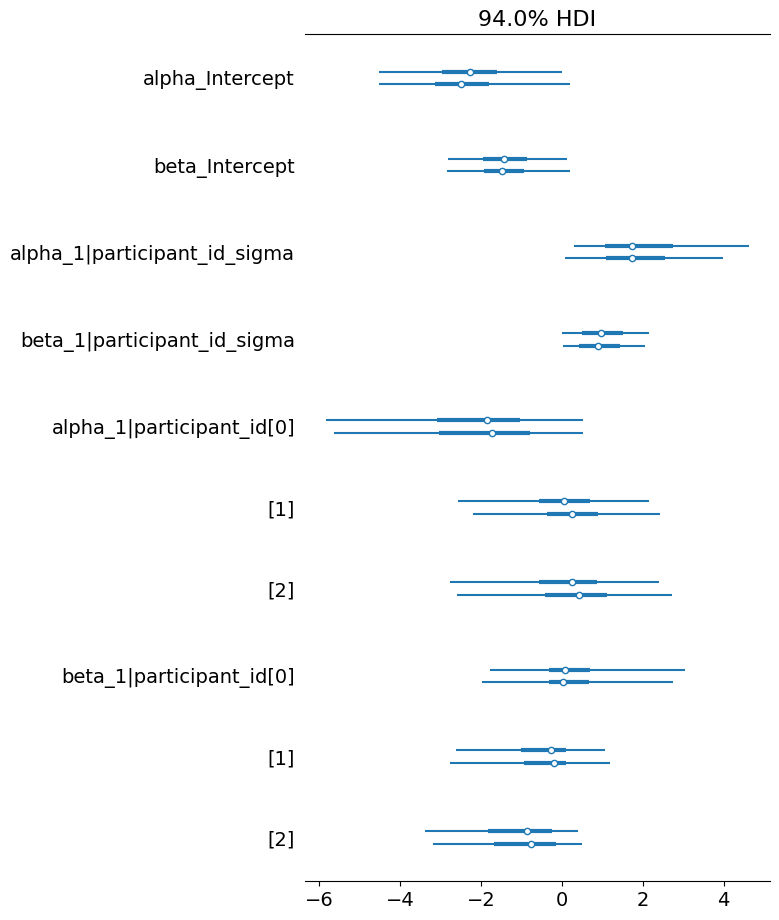

In [ ]:
az.plot_forest(sample, var_names=['~beta'])

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'alpha_Intercept'}>,
        <Axes: title={'center': 'beta_Intercept'}>,
        <Axes: title={'center': 'alpha_1|participant_id_sigma'}>],
       [<Axes: title={'center': 'beta_1|participant_id_sigma'}>,
        <Axes: title={'center': 'alpha_1|participant_id\n0'}>,
        <Axes: title={'center': 'alpha_1|participant_id\n1'}>],
       [<Axes: title={'center': 'alpha_1|participant_id\n2'}>,
        <Axes: title={'center': 'beta_1|participant_id\n0'}>,
        <Axes: title={'center': 'beta_1|participant_id\n1'}>],
       [<Axes: title={'center': 'beta_1|participant_id\n2'}>, <Axes: >,
        <Axes: >]], dtype=object)

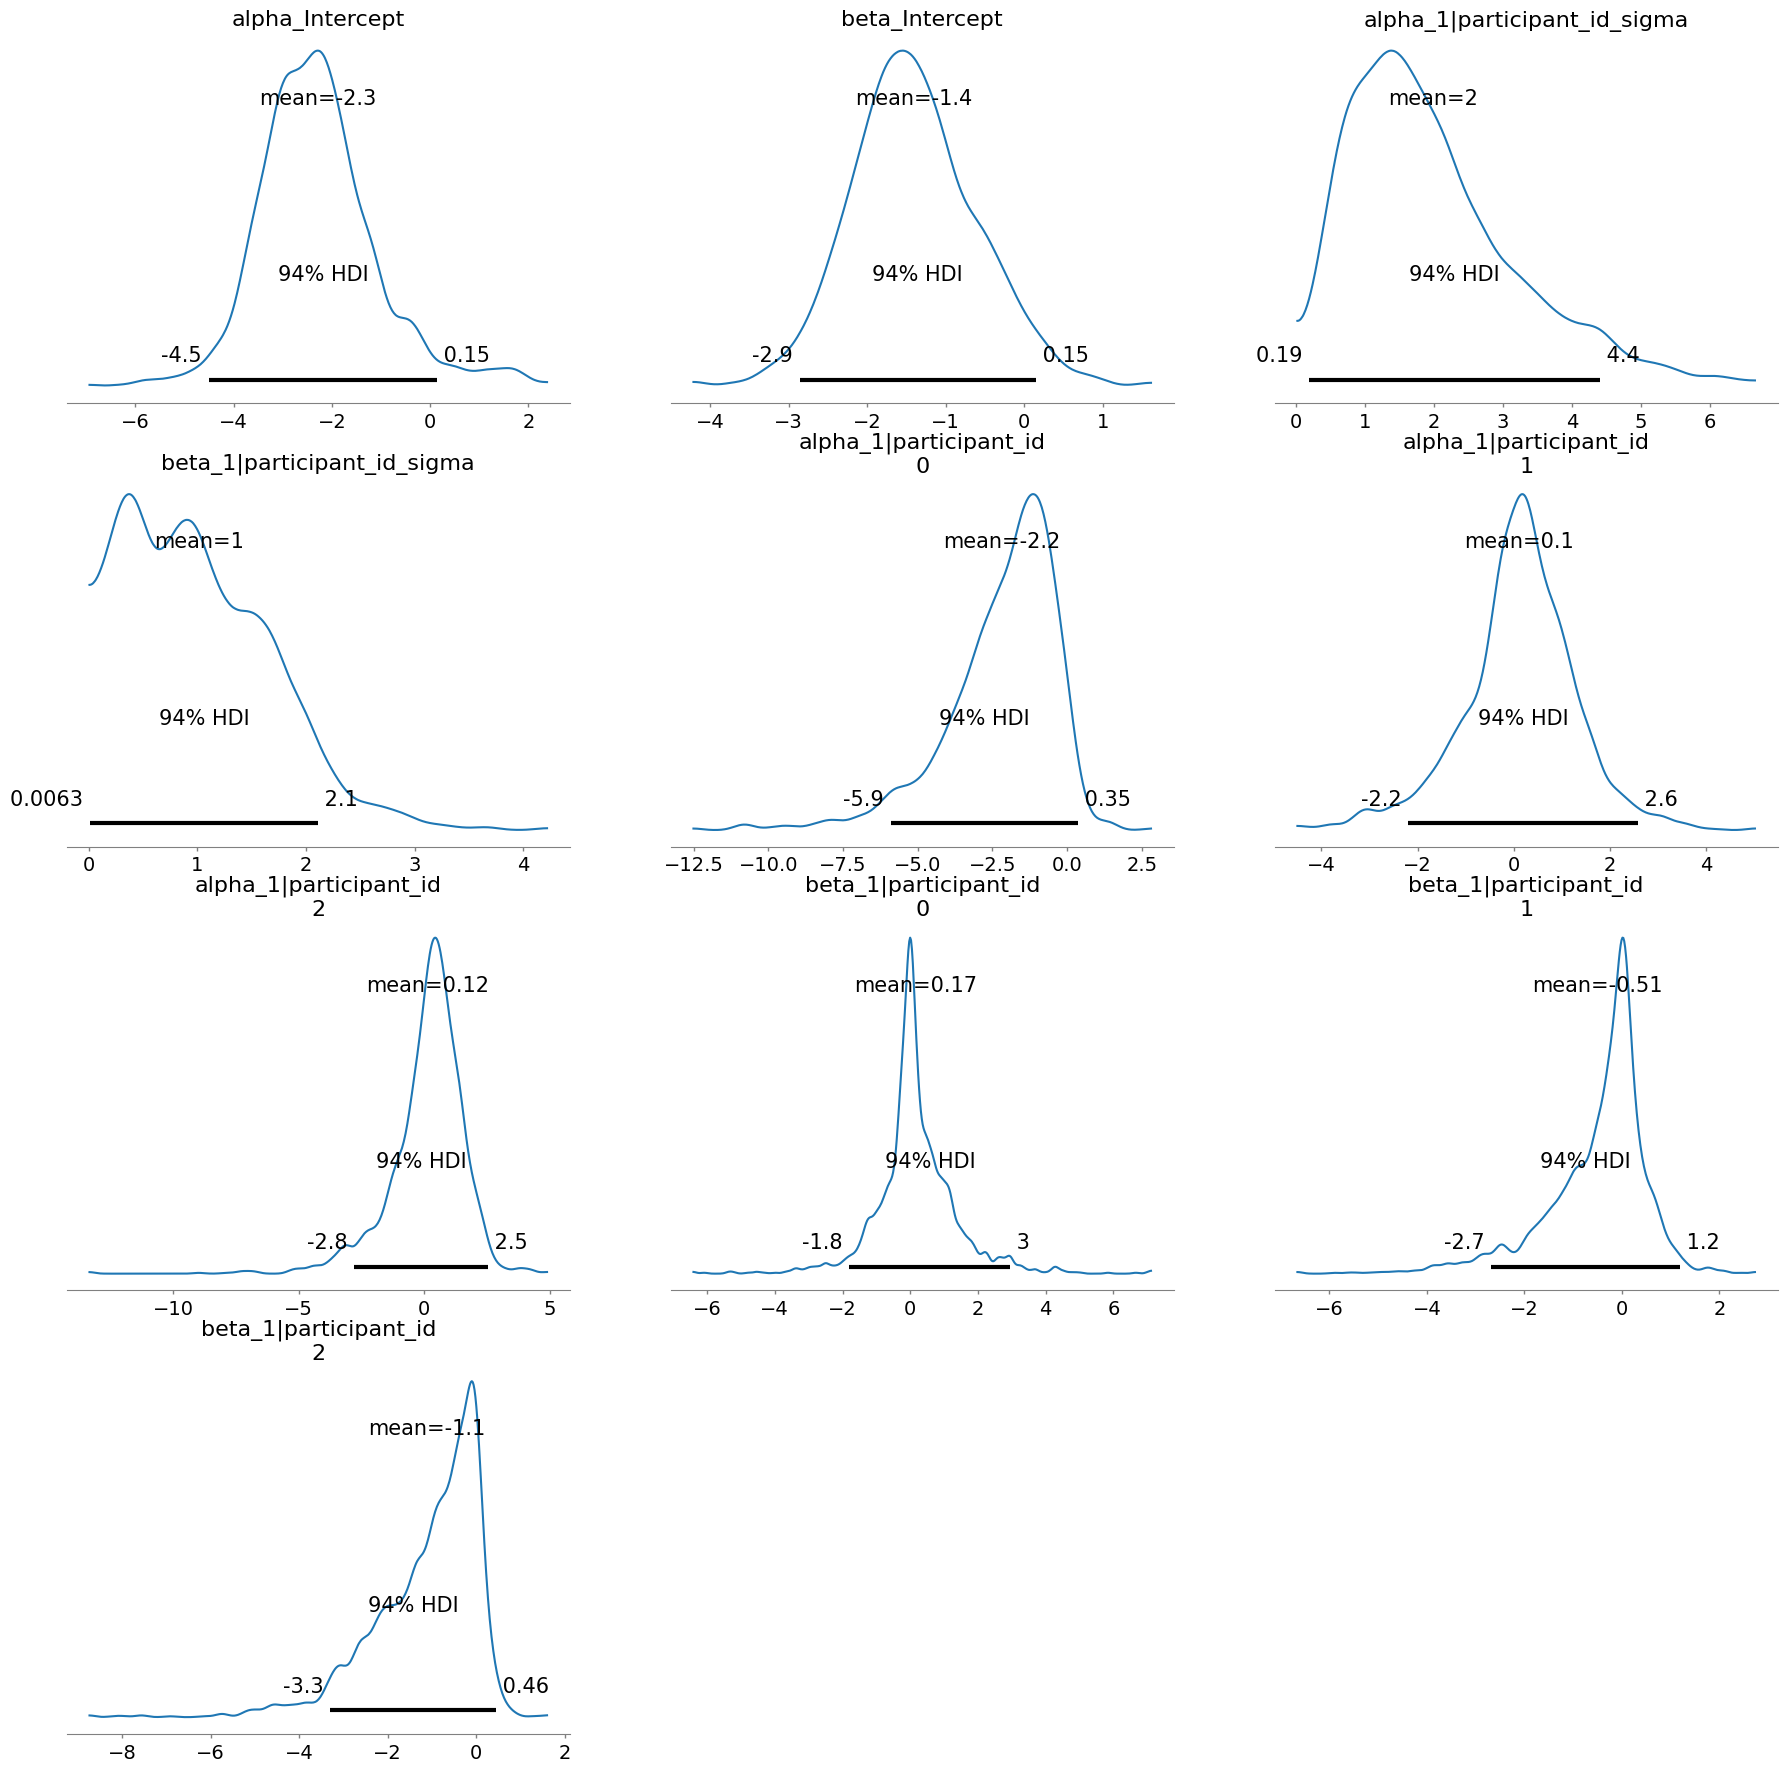

In [ ]:
az.plot_posterior(sample, var_names=['~beta'])